In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.applications.resnet import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import cv2
import math
from IPython.display import clear_output
%matplotlib inline


import os
print(os.listdir("C:/Project/data/img_data"))
print(os.listdir("C:/Project/data/video_data/test_videos"))
print(os.listdir("C:/Project/resnet50/"))

# Any results you write to the current directory are saved as output.

['test', 'train']
['test1.mp4', 'test2.mp4', 'test3.mp4']
['imagenet_class_index.json', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5']


## Data Preparation
The CCTV footage for training and testing is downloaded from publically available videos on Youtube. The training set is prepared by sampling the videos at a constant rate and manually distributing the sampled frames into 'default', 'fire' and 'smoke' categories. Frames are kept in directories named after the class to which  they belong.

In [21]:
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 


In [22]:
def create_model( model_size ):
    my_new_model = Sequential()
    if  model_size == 'L':
        weights='imagenet'
        resnet = ResNet50(include_top=False, pooling='avg', weights=weights)
        resnet.summary()
        my_new_model.add(resnet)
        my_new_model.layers[0].trainable = False
        
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))
   
    # Say no to train first layer (ResNet) model. It is already trained
    
    opt = Adam()
    my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return my_new_model

## Training

The frames for training and testing are read from the directories using ImageDataGenerator.Data augmentation is performed by horizontally flipping each image by setting the horizontal_flip to True in the ImageDataGenerator.

In [23]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            'C:/Project/data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            'C:/Project/data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1 #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return model, train_generator,validation_generator

In [24]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [25]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [26]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)
    

In [27]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()
    #plt.savefig("plot.png")
    

## Prediction

Prediction involves sampling the test videos into frames and predicting the class probabilities in each sampled frame. The class with the maximum probbality is assigned to the frame. However, if the max probablility is less than 0.5, the frame is assigned to the default class.  The predicted class and the class probability is drawn on the frame before writing it into a separate video file using VideoWriter

In [28]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [29]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [30]:
weights='imagenet'
model = create_model('L')

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/20
9/9 [==============================] - 69s 8s/step - loss: 1.1425 - accuracy: 0.4762 - val_loss: 0.5639 - val_accuracy: 1.0000
Epoch 2/20
9/9 [==============================] - 72s 8s/step - loss: 0.5221 - accuracy: 0.8038 - val_loss: 0.5539 - val_accuracy: 1.0000
Epoch 3/20
9/9 [==============================] - 69s 8s/step - loss: 0.3600 - accuracy: 0.8716 - val_loss: 0.3695 - val_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 70s 8s/step - loss: 0.2728 - accuracy: 0.8990 - val_loss: 0.4106 - val_accuracy: 1.0000
Epoch 5/20
9/9 [==============================] - 70s 8s/step - loss: 0.2325 - accuracy: 0.9134 - val_loss: 0.3083 - val_accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 73s 8s/step - loss: 0.2074 - accuracy: 0.9307 - val_loss: 0.4171 - val_accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 69s 8s/step - loss: 0.1916 - accuracy: 0

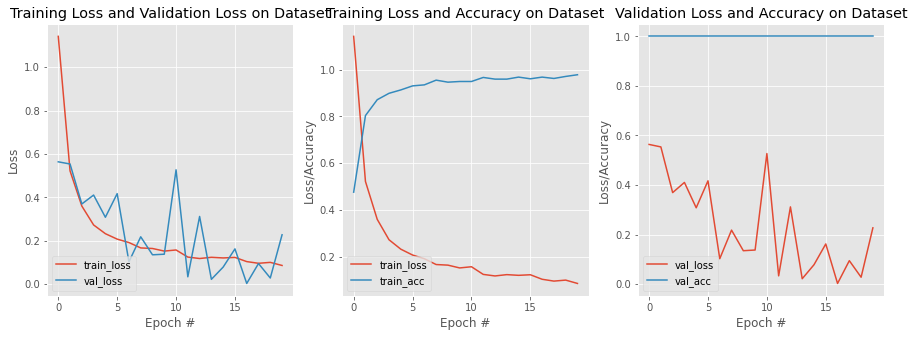

In [31]:
trained_model_l, train_generator,validation_generator = train_model(model)
label_dict_l = get_label_dict(train_generator )
trained_model_l.save('model1.h5')

In [35]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
    #print("count="+str(len(pred_class)) + " txt:" + txt)
    return txt

In [3]:

def predict(  model, video_path, filename, label_dict ):
    url = "http://192.168.0.12:8080/"
    vs = cv2.VideoCapture(url+"video")
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        #print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)       
            frame = draw_prediction( frame, txt )
        #print(pred_class)
        #plt.axis('off')
        #plt.imshow(frame)
        #plt.show()
        #clear_output(wait = True)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
            
        # write the out
        writer.write(frame)
        
    vs.release()
    writer.release()  
   

In [12]:
import ffmpeg
in_file = ffmpeg.input('test1_1.avi')
(
    ffmpeg
    .concat(
        in_file.trim(start_frame=120, end_frame=121),
        in_file.trim(start_frame=0, end_frame=0),
    )
    .output('out3.mp4')
    .run()
)

(None, None)

In [ ]:
import cv2
url = "http://192.168.0.11:8080" # Your url might be different, check the app
vs = cv2.VideoCapture(url+"/video")

while True:
    ret, frame = vs.read()
    if not ret:
        continue
    # Processing of image and other stuff here
    cv2.